# `transformers` meets `bitsandbytes` for democratzing Large Language Models (LLMs) through 4bit quantization

<center>
<img src="https://github.com/huggingface/blog/blob/main/assets/96_hf_bitsandbytes_integration/Thumbnail_blue.png?raw=true" alt="drawing" width="700" class="center"/>
</center>

Welcome to this notebook that goes through the recent `bitsandbytes` integration that includes the work from XXX that introduces no performance degradation 4bit quantization techniques, for democratizing LLMs inference and training.

In this notebook, we will learn together how to load a large model in 4bit (`gpt-neo-x-20b`) and train it using Google Colab and PEFT library from Hugging Face 🤗.

[In the general usage notebook](https://colab.research.google.com/drive/1ge2F1QSK8Q7h0hn3YKuBCOAS0bK8E0wf?usp=sharing), you can learn how to propely load a model in 4bit with all its variants.

If you liked the previous work for integrating [*LLM.int8*](https://arxiv.org/abs/2208.07339), you can have a look at the [introduction blogpost](https://huggingface.co/blog/hf-bitsandbytes-integration) to lean more about that quantization method.


First let's load the model we are going to use - GPT-neo-x-20B! Note that the model itself is around 40GB in half precision

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "EleutherAI/polyglot-ko-12.8b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
# needed for gpt-neo-x tokenizer
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained( 
    model_id, quantization_config=bnb_config, device_map={"":0},
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    )


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/nvidia/lib64')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//matplotlib_inline.backend_inline'), PosixPath('module')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/usr/local/cuda/lib64/libcudart

Loading checkpoint shards:   0%|          | 0/28 [00:00<?, ?it/s]

Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [2]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [3]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [4]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 6553600 || all params: 6608701440 || trainable%: 0.09916622894073424


sft 데이터셋 가져오기

In [5]:
import json
# from google.colab import drive
# drive.mount('/content/drive')

with open('../data/new/sft-smp-10000-w-chat-qna.json', 'r') as f:
    sft = json.load(f)

sft[0]

{'instruction': '문법 오류가 없는 문장을 선택하세요.',
 'input': 'A. 그의 행동은 무책임하고 믿을 수 없을 정도로 유치했다.\nB. 그의 행동은 무책임하고 믿을 수 없을 정도로 유치했다.\nC. 그의 행동은 무책임하고 믿을 수 없을 정도로 유치했다.',
 'output': 'A. "그의 행동은 무책임하고 믿을 수 없을 정도로 유치했다."',
 'history': '',
 'qna': 0.0}

In [6]:
import copy
from dataclasses import dataclass, field
from typing import Optional, Dict, Sequence
import transformers
from torch.utils.data import Dataset
import random
import torch

### for tokenizer
random.seed(777)
IGNORE_INDEX = -100

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
    "prompt_qna": (
        "Below is an instruction that describes a task.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n<|qna_start|>{instruction}<|qna_end|>\n\n### Response:"
    ),
    "prompt_chat": (
        "Below is a dialog, where User interacts with AI. AI is helpful, kind, obedient, honest, and knows its own limits.\n\n"
        "### Instruction:\nWrite the last AI response to complete the dialog.\n\n"
        "### Dialog:\n<|AI|>: 안녕하세요, 무엇을 도와드릴까요?\n{history}\n\n"
        "### Response:\n<|AI|>:"
    )
}

def _tokenize_fn(
    strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer
) -> Dict:
    """Tokenize a list of strings."""
    tokenized_list = [
        tokenizer(
            text,
            return_tensors="pt",
            padding="longest",
            max_length=tokenizer.model_max_length,
            truncation=True,
        )
        for text in strings
    ]
    input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
    input_ids_lens = labels_lens = [
        tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item()
        for tokenized in tokenized_list
    ]
    return dict(
        input_ids=input_ids,
        labels=labels,
        input_ids_lens=input_ids_lens,
        labels_lens=labels_lens,
    )


def preprocess(
    sources: Sequence[str],
    targets: Sequence[str],
    tokenizer: transformers.PreTrainedTokenizer,
) -> Dict:
    """Preprocess the data by tokenizing."""
    examples = [s + t for s, t in zip(sources, targets)]
    examples_tokenized, sources_tokenized = [
        _tokenize_fn(strings, tokenizer) for strings in (examples, sources)
    ]
    input_ids = examples_tokenized["input_ids"]
    labels = copy.deepcopy(input_ids)
    for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
        label[:source_len] = IGNORE_INDEX
    return dict(input_ids=input_ids, labels=labels)


class SupervisedDataset(Dataset):
    """Dataset for supervised fine-tuning."""

    def __init__(self, data_path: str, tokenizer: transformers.PreTrainedTokenizer):
        super(SupervisedDataset, self).__init__()
        print("Loading data...")
        with open(data_path, 'r') as f:
            list_data_dict = json.load(f)
        random.shuffle(list_data_dict)  # shuffle data

        print("Formatting inputs...")
        prompt_input, prompt_no_input, prompt_chat, prompt_qna = (
            PROMPT_DICT["prompt_input"],
            PROMPT_DICT["prompt_no_input"],
            PROMPT_DICT["prompt_chat"],
            PROMPT_DICT["prompt_qna"],
        )
#         sources = [
#             prompt_input.format_map(example)
#             if example.get("input", "") != ""
#             else prompt_no_input.format_map(example)
#             for example in list_data_dict
#         ]
        sources = []
        for example in list_data_dict:
            if example.get("qna", 0) == 1:
                exfmt = prompt_qna.format_map(example)
            elif example.get("history", "") != "":
                exfmt = prompt_chat.format_map(example)
            elif example.get("input", "") != "":
                exfmt = prompt_input.format_map(example)
            else:
                exfmt = prompt_no_input.format_map(example)
            sources.append(exfmt)
        targets = [
            f"{example['output']}{tokenizer.eos_token}" for example in list_data_dict
        ]

        print("Tokenizing inputs... This may take some time...")
        data_dict = preprocess(sources, targets, tokenizer)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])


@dataclass
class DataCollatorForSupervisedDataset(object):
    """Collate examples for supervised fine-tuning."""

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple(
            [instance[key] for instance in instances] for key in ("input_ids", "labels")
        )
        # print("[input_ids]:", tokenizer.decode(input_ids))
        # print("[labels]:", labels)
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(
            labels, batch_first=True, padding_value=IGNORE_INDEX
        )
        ret = dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )
        # print(ret)
        return ret


def make_supervised_data_module(
    tokenizer: transformers.PreTrainedTokenizer, data_path
) -> Dict:
    """Make dataset and collator for supervised fine-tuning."""
    train_dataset = SupervisedDataset(
        tokenizer=tokenizer, data_path=data_path
    )
    data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)
    return dict(
        train_dataset=train_dataset, eval_dataset=None, data_collator=data_collator
    )



Run the cell below to run the training! For the sake of the demo, we just ran it for few steps just to showcase how to use this integration with existing tools on the HF ecosystem.

In [7]:
tokenizer.model_max_length = 2048  # chat 데이터 추가시 반드시 2048 까지는 늘려줘야 함
data_path = '../data/new/sft-smp-10000-w-chat-qna.json'
# data_path = '/content/drive/MyDrive/gpt/sft-smp-1000.json'

data_module = make_supervised_data_module(tokenizer=tokenizer, data_path=data_path)

Loading data...
Formatting inputs...
Tokenizing inputs... This may take some time...


In [8]:
n = 13
print(''.join(tokenizer.batch_decode(data_module['train_dataset'][n]['input_ids'])))
# print(''.join(tokenizer.batch_decode(data_module['train_dataset'][n]['labels'])))
# data_module['train_dataset'][0]

Below is an instruction that describes a task.

Write a response that appropriately completes the request.

### Instruction:
<|qna_start|>연금저축계좌에 입금 시 한도금액을 초과하여 기타수취오류가 표시됩니다.<|qna_end|>

### Response:연금저축계좌는 사전에 설정한 납입한도 내에서 입금 가능하오니 아래의 경로에서 납입한도를 확인해 보시기 바랍니다.
�� 홈페이지 > 고객서비스 > 온라인/계좌관리 > 연금계좌관리 > 개인연금/비과세종합저축 정보변경
�� 한국투자앱 > 메뉴 > 금융상품 > 개인연금/IRP > 나의 개인연금 > 납입한도 적립기간변경
�� 연금저축계좌의 연간 납입금액은 전 금융기관 통합한도(1,800만원)로 관리되며, 당사에 증액 가능한 한도가 남아있지 않은 경우
    다른 금융기관에 설정한 내역이 있는지 해당 기관으로 확인해 보시기 바랍니다. 
�� 통합한도관리 = ① 연금저축계좌 + ② 퇴직연금(DC/IRP) 가입자 추가부담금 + ③ 퇴직연금(과학기술인공제회)<|endoftext|>


In [9]:
import transformers

trainer = transformers.Trainer(
    model=model,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=6,
        gradient_accumulation_steps=32,
        learning_rate=2e-5,
        warmup_ratio=0.03,
        lr_scheduler_type='cosine',
        weight_decay=0,
#         num_train_epochs=15,
        num_train_epochs=8,
        save_strategy="epoch",
#         save_steps=1000,
        save_total_limit=5,
        report_to="none",
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit",
    ),
    # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    **data_module,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Step,Training Loss
1,2.094300
2,2.150000
3,2.226700
4,2.187600
5,2.191800
6,2.085900
7,2.233700
8,2.176300
9,2.161300
10,2.103100


TrainOutput(global_step=456, training_loss=1.6012072895179714, metrics={'train_runtime': 145650.523, 'train_samples_per_second': 0.609, 'train_steps_per_second': 0.003, 'total_flos': 3.4929805523071795e+18, 'train_loss': 1.6012072895179714, 'epoch': 7.9})

In [10]:
# save lora
model.save_pretrained('lora-qna-13b')

# merge lora weight
# https://github.com/huggingface/peft/blob/main/src/peft/tuners/lora.py#L409
# merged_lora_model = model.merge_and_unload()

# # save merged model
# merged_lora_model.save_pretrained("outputs")


In [14]:
import pandas as pd
df = pd.DataFrame(trainer.state.log_history)
df

,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.0943,1.428571e-06,0.02,1,NaN,NaN,NaN,NaN,NaN
1,2.1500,2.857143e-06,0.03,2,NaN,NaN,NaN,NaN,NaN
2,2.2267,4.285714e-06,0.05,3,NaN,NaN,NaN,NaN,NaN
3,2.1876,5.714286e-06,0.07,4,NaN,NaN,NaN,NaN,NaN
4,2.1918,7.142857e-06,0.09,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
452,1.5220,2.273271e-09,7.84,453,NaN,NaN,NaN,NaN,NaN
453,1.4863,1.010364e-09,7.86,454,NaN,NaN,NaN,NaN,NaN
454,1.4606,2.525942e-10,7.88,455,NaN,NaN,NaN,NaN,NaN
455,1.4882,0.000000e+00,7.90,456,NaN,NaN,NaN,NaN,NaN


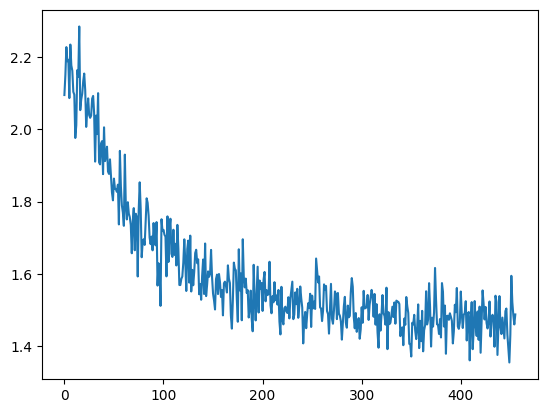

In [12]:
import matplotlib.pyplot as plt

plt.plot(df['loss'])

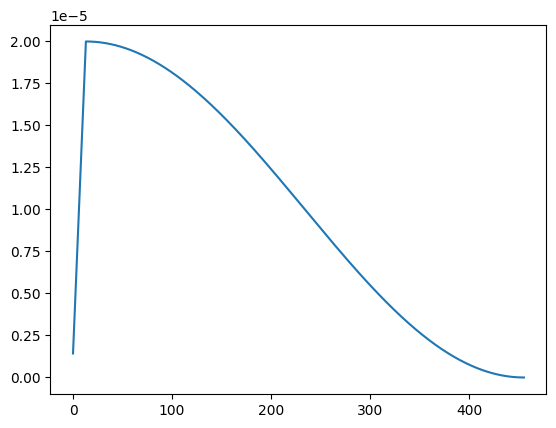

In [15]:
plt.plot(df['learning_rate'])

In [ ]:
aa = [(k,v.dtype) for k,v in mm.state_dict().items()]
bb = [(k,v.dtype) for k,v in model.state_dict().items()]

In [ ]:
len(aa), len(bb)
for a, b in zip(aa, bb):
    if a[1] != b[1]:
        print(a[0], a[1], b[1])
        print('----')

In [ ]:
aa

In [ ]:
!du -h -d 1 ~/.cache/huggingface/hub

In [ ]:
tokenizer.pad_token_id, tokenizer.eos_token_id

In [ ]:
    model.state_dict()[
        "base_model.model.gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight"
    ][0]

## Inference test

In [2]:
# load merged model
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = 'cuda'
model_id = "merged-qna-13b"

tokenizer = AutoTokenizer.from_pretrained('EleutherAI/polyglot-ko-12.8b')
tokenizer.pad_token = tokenizer.eos_token  # needed for gpt-neo-x tokenizer

model = AutoModelForCausalLM.from_pretrained(
      model_id,
      torch_dtype=torch.float16,
      # torch_dtype='auto',
      low_cpu_mem_usage=True,
      pad_token_id=tokenizer.pad_token_id,
      eos_token_id=tokenizer.eos_token_id
    )

model = model.to(DEVICE)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# load original model and lora weight and adapt it
# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM
# from peft import PeftModel, PeftConfig

# DEVICE = 'cuda'
# peft_model_id = "lora-qnat"
# config = PeftConfig.from_pretrained(peft_model_id)


# tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
# tokenizer.pad_token = tokenizer.eos_token  # needed for gpt-neo-x tokenizer

# model = AutoModelForCausalLM.from_pretrained(
#       config.base_model_name_or_path,
#       torch_dtype=torch.float16,
#       # torch_dtype='auto',
#       low_cpu_mem_usage=True,
#       pad_token_id=tokenizer.pad_token_id,
#       eos_token_id=tokenizer.eos_token_id
#     )
# PeftModel.from_pretrained(model, peft_model_id)

# model = model.to(DEVICE)
# model.eval()


In [23]:
from time import time

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
    "prompt_qna": (
        "Below is an instruction that describes a task.\n\n"
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n<|qna_start|>{instruction}<|qna_end|>\n\n### Response:"
    ),
#     "prompt_chat": (
        
#         "Below is a dialog, where User interacts with AI. AI is helpful, kind, obedient, honest, and knows its own limits.\n\n"
#         "### Instruction:\nWrite the last AI response to complete the dialog.\n\n"
#         "### Dialog:\n<|AI|>: 안녕하세요, 무엇을 도와드릴까요?\n{history}\n\n"
#         "### Response:\n<|AI|>:"
#     ),
    "prompt_chat": (
        
        "Below is a dialog, where User interacts with AI. AI is helpful, kind, obedient, honest, and knows its own limits.\n\n"
        "### Instruction:\nWrite the last AI response to complete the dialog.\n\n"
        "### Dialog:\n<|AI|>: 안녕하세요, 무엇을 도와드릴까요?\n{history}\n<|AI|>:\n\n"
        "### Response:\n"
    )
}

def gen(prompt, input=None, is_qna=False, min_new_tokens=10, max_new_tokens=128, temperature=0.5, **kwargs):
    st = time()
    if is_qna:
        x = PROMPT_DICT['prompt_qna'].format(instruction=prompt)
    elif user_input:
        x = PROMPT_DICT['prompt_input'].format(instruction=prompt, input=input)
    else:
        x = PROMPT_DICT['prompt_no_input'].format(instruction=prompt)

    input_ids = tokenizer.encode(x, return_tensors="pt").to(DEVICE)
    gen_tokens = model.generate(
        inputs = input_ids,
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        temperature=temperature,
        no_repeat_ngram_size=6,
        do_sample=True,
        **kwargs
    )
    gen_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)
    end = time()
    print(f"[Elpsed]: {end-st} sec")

    return x, gen_text.replace(x, ''), gen_tokens


def dialog_gen(user_input, history=None, max_new_tokens=128, temperature=0.5, **kwargs):
    st = time()
    if history is None:
        history = []
    history.append({'agent': 'User', 'utterance': user_input})
    history_str = [f"<|{x['agent']}|>: {x['utterance']}" for x in history]
    history_str = '\n'.join(history_str)
    x = PROMPT_DICT['prompt_chat'].format(history=history_str)
    
    input_ids = tokenizer.encode(x, return_tensors="pt").to(DEVICE)
    gen_tokens = model.generate(
        inputs=input_ids, 
        max_new_tokens=max_new_tokens, 
        num_return_sequences=1, 
        temperature=temperature,
        no_repeat_ngram_size=6,
        do_sample=True,
        **kwargs
        
    )
    gen_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)
    response = gen_text.replace(x, '')
    history.append({'agent': 'AI', 'utterance': response})
    end = time()
    print(f"[Elpsed]: {end-st} sec")
    
    return x, response, gen_tokens


In [11]:
history = []
# history = [
#     {'agent': '', 'utterance': ''}
# ]

In [12]:
DEVICE = 'cuda'
with torch.no_grad():
    user_input = '나 지금 너무 배고프다.'
#     user_input = '굿굿 뭐가 자신있는데?'
#     user_input = '엥? 뭔소리야 빡치게.'
#     user_input = '너 누구야...'
#     user_input = '중국요리 먹고싶은데 몇 가지 추천해줘.'
#     user_input = '좋아 그럼 식당도 같이 추천해줘.'
#     user_input = '식당 추천해줘.'
#     user_input = '돈부리는 처음 듣는데 이건 무슨 음식이야?'


    prompt, generated_output, gen_tokens = dialog_gen(user_input, history, max_new_tokens=256, temperature=0.1, repetition_penalty=1.4)
    print(generated_output)

    print('---')
    print(history)

[Elpsed]: 0.2739570140838623 sec
`~'
---
[{'agent': 'User', 'utterance': '나 지금 너무 배고프다.'}, {'agent': 'AI', 'utterance': "`~'"}]


In [13]:
print(prompt)

Below is a dialog, where User interacts with AI. AI is helpful, kind, obedient, honest, and knows its own limits.

### Instruction:
Write the last AI response to complete the dialog.

### Dialog:
<|AI|>: 안녕하세요, 무엇을 도와드릴까요?
<|User|>: 나 지금 너무 배고프다.
<|AI|>:

### Response:



In [32]:
DEVICE = 'cuda'
with torch.no_grad():
    for i in range(1):
#         prompt, generated_ouput, gen_tokens = gen('계좌 종류에 대해 자세히 설명해줘', is_qna=True, max_new_tokens=256, temperature=0.8)
#         prompt, generated_ouput, gen_tokens = gen('월별 실현손익 조회 방법', is_qna=True, max_new_tokens=256, temperature=0.8)
        prompt, generated_ouput, gen_tokens = gen('개인 대주거래 서비스를 활용하려면 어떻게 해야 하나요?', is_qna=True, max_new_tokens=256, temperature=0.8)
        
        if i == 0:
            print(prompt, '\n', generated_ouput)
        else:
            print(generated_ouput)
        print('='*80, '\n')

[Elpsed]: 4.962015628814697 sec
Below is an instruction that describes a task.

Write a response that appropriately completes the request.

### Instruction:
<|qna_start|>개인 대주거래 서비스를 활용하려면 어떻게 해야 하나요?<|qna_end|>

### Response: 
 개인 대주거래 서비스는 신용 및 담보대출을 이용하여 주식을 매매하는 서비스로, 신용거래가 가능한 계좌를 보유한 고객이라면 온라인상에서 손쉽게 이용 가능합니다.
한국투자증권 뱅키스계좌를 보유한 고객은 HTS 및 홈페이지상에서, 타 금융기관 계좌를 이용하는 고객은 한국투자 앱을 통해 이용 가능합니다.



In [30]:
DEVICE = 'cuda'
pp = '''\
질문: 철수는 테니스공을 5개 가지고 있다. 철수는 테니스공 2캔을 더 산다. 각각의 캔에는 3개의 테니스공을 가지고 있다. 철수는 지금 테니스 공을 몇 개가지고 있는가?
답: 11
###
질문: 식당에는 23개의 사과가 있었다. 만약 점심을 만드는데 20개를 사용하고 6개를 더 샀다면, 사과는 얼마나 남아있는가?
답: 9
###
질문: 철수는 오늘 사탕을 2개 먹었다. 영희가 사탕 3개를 선물해줬다. 철수는 사탕 1개를 현아에게 주고 나머지 사탕을 전부 먹었다. 철수는 총 몇개의 사탕을 먹었는가?
답: 4
###
질문: 전시장 앞에 자동차 10대가 주차된 상태다. 자동차 6대가 더 주차했다. 3대의 자동차가 주차장을 빠져나왔다. 총 몇 대의 차가 주차되어 있는가?
답: 
'''

pp_cot = '''\
질문: 철수는 테니스공을 5개 가지고 있다. 철수는 테니스공 2캔을 더 산다. 각각의 캔에는 3개의 테니스공을 가지고 있다. 철수는 지금 테니스 공을 몇 개 가지고 있는가?
답: 철수는 5개의 공으로 시작했다. 테니스공 1캔에는 3개의 공이 들어있으므로 2캔에는 총 6개의 테니스공이 있다. 5+6=11. 정답은 11 이다.
###
질문: 식당에는 23개의 사과가 있었다. 만약 점심을 만드는데 20개를 사용하고 6개를 더 샀다면, 사과는 얼마나 남아있는가?
답: 식당에는 원래 23개의 사과가 있었다. 점심을 만드는데 20개를 사용했다. 23-20=3. 사과를 6개 더 샀기 때문에 3+6=9. 정답은 9 이다.
###
질문: 철수는 오늘 사탕을 2개 먹었다. 영희가 사탕 3개를 선물해줬다. 철수는 사탕 1개를 현아에게 주고 나머지 사탕을 전부 먹었다. 철수는 총 몇개의 사탕을 먹었는가?
답: 철수는 사탕 2개를 이미 먹었다. 영희가 선물해준 사탕 3개 중에서 1개는 현아에게 줬다. 3-1=2. 나머지 사탕 2개를 먹었으므로 2+2=4. 정답은 4다.
###
질문: 전시장 앞에 자동차 10대가 주차된 상태다. 자동차 6대가 더 주차했다. 3대의 자동차가 주차장을 빠져나왔다. 총 몇 대의 차가 주차되어 있는가?
답: 
'''
with torch.no_grad():
    for i in range(1):
        prompt, generated_ouput, gen_tokens = gen('크루아상을 만드는 방법을 자세히 설명해줘', max_new_tokens=256, temperature=0.8)
#         prompt, generated_ouput, gen_tokens = gen('주어진 문장의 어투를 10대 어린아이의 말투로 스타일을 변경해줘 \n\n"OpenAI의 GPT-3와 GPT-4와 같은 모델은 Large Language Model의 좋은 예시로, 광범위한 언어 패턴을 이해하고, 사용자의 입력에 대해 의미 있는 출력을 생성할 수 있습니다. 이들은 다양한 언어 작업을 수행할 수 있으며, 직접적인 교육을 받지 않은 작업들에 대해서도 일정 수준의 성능을 발휘할 수 있습니다."',
#                                                   max_new_tokens=256, temperature=0.8)

#         prompt, generated_ouput, gen_tokens = gen('일반상대성이론과 특수상대성이론해 대해 자세히 설명해줘', max_new_tokens=256, temperature=0.8)
#         prompt, generated_ouput, gen_tokens = gen('피카츄를 얻으려면 어떻게 해야해?', max_new_tokens=256, temperature=0.8)
#         prompt, generated_ouput, gen_tokens = gen('한국에서 제일 유명한 노래와 그 곡을 부른 가수를 소개해줘.', max_new_tokens=256, temperature=0.8)
#         prompt, generated_ouput, gen_tokens = gen('양념치킨 어디가 싸고 맛있냐?', max_new_tokens=256, temperature=0.8)
#         prompt, generated_ouput, gen_tokens = gen(pp_cot, max_new_tokens=512, temperature=0.8)
        if i == 0:
            print(prompt, '\n', generated_ouput)
        else:
            print(generated_ouput)
        print('='*80, '\n')

[Elpsed]: 4.567317485809326 sec
Below is an instruction that describes a task, paired with an input that provides further context.

Write a response that appropriately completes the request.

### Instruction:
크루아상을 만드는 방법을 자세히 설명해줘

### Input:
None

### Response: 
 크루아상을 만들려면 밀가루, 버터, 설탕, 계란, 소금을 섞어 반죽을 만든 후, 잘 펴서 오븐에 넣고 구워주면 됩니다. 크루아상의 크기와 두께는 반죽의 양과 오븐의 온도에 따라 달라집니다. 크루아상 위에 잼이나 초콜릿 등을 발라 먹을 수도 있습니다.



---
# for merge test

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import (
    get_peft_model,
    get_peft_config,
    get_peft_model_state_dict,
    LoraConfig,
    PeftModel,
    PeftConfig,
)
import pickle

DEVICE = "cuda"
peft_model_id = "lora-qna-13b"
config = PeftConfig.from_pretrained(peft_model_id)


tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token  # needed for gpt-neo-x tokenizer

model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    torch_dtype=torch.float16,
    # torch_dtype='auto',
    low_cpu_mem_usage=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

# 이거는 transformer model임
# 인퍼런스에선 이걸로 사용하면 편함 *.bin 으로 저장된 lora adapter 가중치 로드가능
PeftModel.from_pretrained(model, peft_model_id)

# 모델 로드 체크용 가중치
chk = (
    model.state_dict()[
        "gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight"
    ][0]
    .cpu().numpy()
    .copy()
)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/nvidia/lib64')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/usr/local/cuda/lib64/libcudart

Loading checkpoint shards:   0%|          | 0/28 [00:00<?, ?it/s]

In [2]:
### save lora weight as pickle
# lw = get_peft_model_state_dict(model)

lw = list(filter(lambda x: "lora" in x[0], model.state_dict().items()))
lw = dict(lw)
print("[lora # layer]:", len(lw))
with open("./lora-qna-13b/lora-weight.pkl", "wb") as f:
    pickle.dump(lw, f)


# lora merge 하려면 peftModel 객체로 변환해야 함
# 학습시 사용한 값 그대로임
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    inference_mode=False,
)
# 이거 하는 순간 웨이트 초기화 될수도...
# -> 맞네...
model = get_peft_model(model, peft_config)
chk2 = (
    model.state_dict()[
        "base_model.model.gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight"
    ][0]
    .cpu()
    .numpy()
    .copy()
)

[lora # layer]: 80


In [3]:
# model.state_dict()['gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight']
# model.state_dict()['base_model.model.gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight']
# peft model 은 'base_model.model' 부분이 키앞에붙는거주의

# model = get_peft_model(model, peft_config)


## LOAD pickle format LORA Weights
def load_model(model, weights):
    model.load_state_dict(weights, strict=False)
    return model


with open("./lora-qna-13b/lora-weight.pkl", "rb") as f:
    lw = pickle.load(f)
    new_lw = {f"base_model.model.{k}": v for k, v in lw.items()}

model = load_model(model, new_lw)  # .to(DEVICE)
chk3 = (
    model.state_dict()[
        "base_model.model.gpt_neox.layers.0.attention.query_key_value.lora_A.default.weight"
    ][0]
    .cpu()
    .numpy()
    .copy()
)

# check
print(f"[orig   lora W]: {chk}")
print(f"[init   lora W]: {chk2}")
print(f"[loaded lora W]: {chk3}")

### merge and save

# merge lora weight
# https://github.com/huggingface/peft/blob/main/src/peft/tuners/lora.py#L409
model.merge_and_unload()

# peftModel -> transformer.model
mm = model.base_model._modules["model"]
type(mm)
# save merged model
# mm.save_pretrained("model")

# ggml 컨버팅 위해 아래 토크나이저 정보 파일 'output'폴더에 같이 옮겨둬야 함
# - special_tokens_map.json
# - tokenizer_config.json
# - tokenizer.json

len(mm.state_dict())
# 424 -> 480 -> 424

[orig   lora W]: [ 0.01055178 -0.00999201 -0.0093959  ...  0.01011845  0.00611774
 -0.00790966]
[init   lora W]: [-0.00353835  0.01148791  0.00037218 ...  0.00603641  0.00043564
 -0.01093728]
[loaded lora W]: [ 0.01055178 -0.00999201 -0.0093959  ...  0.01011845  0.00611774
 -0.00790966]


604

In [6]:
mm.to('cuda')
mm.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(30080, 5120)
    (layers): ModuleList(
      (0-39): 40 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
        (attention): GPTNeoXAttention(
          (rotary_emb): RotaryEmbedding()
          (query_key_value): Linear(in_features=5120, out_features=15360, bias=True)
          (dense): Linear(in_features=5120, out_features=5120, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=5120, out_features=20480, bias=True)
          (dense_4h_to_h): Linear(in_features=20480, out_features=5120, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
  )
  (embed_out): Linear(in_features=5120, out_features=30080, bias=False)
)

In [7]:
mm.device

device(type='cuda', index=0)

In [8]:
del model

In [10]:
model = mm

In [18]:
mm.save_pretrained("merged-qna-13b")